# Assignment 3: Agentic RAG System with Azure OpenAI, Pinecone & LangGraph

### Author: Shubhda Datta
### Python: 3.10

In [1]:
#!python -m pip install langchain-community langchainhub langchain-chroma langchain langchain-experimental --quiet
#!python -m pip install pypdf faiss-cpu --quiet
#!python -m pip install pinecone --quiet

### Setup and Imports

In [2]:
import os,json, time
import mlflow
import pandas as pd
import logging
from typing import Dict, Any, List, Tuple, Optional
import pinecone

from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_community.vectorstores import Chroma

from azure.ai.inference import EmbeddingsClient, ChatCompletionsClient
from azure.core.credentials import AzureKeyCredential
from langgraph.graph import StateGraph, END


/home/zadmin/Desktop/GAAI-B4-Azure/genai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Logging Setup


In [3]:

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)


In [4]:

embedding_model_name = "text-embedding-3-small"
llm_model_name = "gpt4o"

### Initialize Embedding and llm Model

In [5]:

def init_openai_clients() -> Tuple[AzureOpenAIEmbeddings, AzureChatOpenAI]:
    """Initialize Azure OpenAI embeddings and chat models."""
    api_key = os.getenv("AZURE_OPENAI_API_KEY")
    endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    version = os.getenv("AZURE_OPENAI_API_VERSION")

    if not api_key or not endpoint:
        raise EnvironmentError("Azure OpenAI credentials are not set.")

    embeddings = AzureOpenAIEmbeddings(
    model=embedding_model_name,
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    api_version=os.environ.get("AZURE_OPENAI_API_VERSION", "2024-02-01"),
    )

    llm = AzureChatOpenAI(
        model=llm_model_name,
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        api_version=os.environ.get("AZURE_OPENAI_API_VERSION", "2024-02-01"),
        temperature=0
    )
    return embeddings, llm

In [6]:
embeddings, llm=init_openai_clients()

In [7]:
embeddings

AzureOpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x75e89fbd0b60>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x75e89f2a0d10>, model='text-embedding-3-small', dimensions=None, deployment=None, openai_api_version='2024-08-01-preview', openai_api_base=None, openai_api_type='azure', openai_proxy=None, embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=2048, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True, azure_endpoint='https://eastus.api.cognitive.microsoft.com/', azure_ad_token=None, azure_ad_token_provider=None, azure_ad_async_token_provider=None, validate_base_url=Tr

In [8]:
llm

AzureChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x75e89ed8a7b0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x75e89ef682f0>, root_client=<openai.lib.azure.AzureOpenAI object at 0x75e89ed5fd70>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x75e89ed8a810>, model_name='gpt4o', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), disabled_params={'parallel_tool_calls': None}, azure_endpoint='https://eastus.api.cognitive.microsoft.com/', openai_api_version='2024-08-01-preview', openai_api_type='azure')

### Load Dataset

In [9]:
AZURE_EMBEDDING_DEPLOYMENT = embedding_model_name
AZURE_CHAT_DEPLOYMENT = llm_model_name
AZURE_API_KEY = os.getenv("AZURE_API_KEY")
AZURE_ENDPOINT = os.getenv("AZURE_ENDPOINT")

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_ENV = os.getenv("PINECONE_ENV")
INDEX_NAME = "agentic-rag"

DATA_FILE = "self_critique_loop_dataset.json"

In [10]:
!python -m pip install pinecone --quiet

In [11]:
import os
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
print(PINECONE_API_KEY)

pcsk_3sQW5Q_D5rWa1uWzhFCrXyLeupVQgjKn8onPJ7PVVtdb45bvkw9Aa4Yb9cA9gMdvD9T7qd


In [12]:
from pinecone import Pinecone
pc = Pinecone(api_key=PINECONE_API_KEY)

In [13]:

# ------------------------------------------------------
# 🔹 Initialize Pinecone
# ------------------------------------------------------
from pinecone import Pinecone
try:
    pc = Pinecone(api_key=PINECONE_API_KEY)
    
except Exception as e:
    logger.error(f"Initialization error: {e}")
    raise e
index = pc.Index("agentic-rag")

In [14]:
from pinecone import Pinecone, ServerlessSpec
import os

pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

index_name = "agentic-rag"

# Delete if exists
if index_name in [idx.name for idx in pc.list_indexes()]:
    pc.delete_index(index_name)

# Create with correct dimension
pc.create_index(
    name=index_name,
    dimension=1536,   # must match Azure embedding model
    metric="cosine",
    spec=ServerlessSpec(cloud="aws", region="us-east-1")
)


{
    "name": "agentic-rag",
    "metric": "cosine",
    "host": "agentic-rag-w3zw5h2.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 1536,
    "deletion_protection": "disabled",
    "tags": null
}

In [15]:
query = "What are best practices for caching?"
query_vector = embeddings.embed_query(query)
query_res = index.query(
    vector=query_vector,
    top_k=5,
    include_metadata=True
)

2025-10-04 00:38:10,390 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


In [16]:
query_res

{'matches': [], 'namespace': '', 'usage': {'read_units': 1}}

In [17]:
def azure_chat(prompt: str, temperature: float = 0.0) -> str:
    """Call Azure GPT-4 mini safely."""
    try:
        response = llm.complete(
            model=AZURE_CHAT_DEPLOYMENT,
            messages=[{"role": "user", "content": prompt}],
            temperature=temperature,
            max_tokens=500
        )
        return response.choices[0].message["content"]
    except Exception as e:
        logger.error(f"Chat completion error: {e}")
        return "ERROR: LLM failed."

In [18]:
def index_kb():
    """Load KB JSON and index into Pinecone."""
    with open(DATA_FILE, "r") as f:
        kb_data = json.load(f)

    for i, entry in enumerate(kb_data):
        # Combine question + answer for better embedding context
        doc_text = f"Q: {entry['question']} A: {entry['answer_snippet']}"

        vector = embeddings.embed_query(doc_text)
        if not vector:
            continue

        try:
            index.upsert([
                (
                    entry["doc_id"],   # use KB001, KB002 as ID
                    vector,
                    {
                        "question": entry["question"],
                        "answer_snippet": entry["answer_snippet"],
                        "source": entry["source"],
                        "confidence": entry.get("confidence_indicator", "unknown"),
                        "last_updated": entry.get("last_updated", "")
                    }
                )
            ])
        except Exception as e:
            logger.warning(f"Indexing error for {entry['doc_id']}: {e}")

    logger.info("KB indexing complete.")

index_kb()

2025-10-04 00:38:11,789 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-10-04 00:38:13,209 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-10-04 00:38:13,988 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-10-04 00:38:14,736 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-10-04 00:38:15,750 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-10-04 00:3

In [19]:
from pydantic import BaseModel, Field
from typing import List, Dict, Optional

class RAGState(BaseModel):
    query: str
    retrieved_snippets: List[Dict] = Field(default_factory=list)
    initial_answer: Optional[str] = None
    critique_complete: Optional[bool] = None
    refined_answer: Optional[str] = None


In [20]:
class CritiqueResult(BaseModel):
    is_complete: bool = Field(..., description="Whether the answer is complete (True) or needs refinement (False).")


In [21]:
from langgraph.graph import START, StateGraph, END
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
import os


# --- Node 1: Retriever ---

def retriever_node(state: RAGState):
    query_vector = embeddings.embed_query(state.query)
    res = index.query(vector=query_vector, top_k=5, include_metadata=True)

    snippets = []
    for match in res.matches:
        snippets.append({
            "id": match.id,
            "score": match.score,
            "question": match.metadata.get("question", ""),
            "answer_snippet": match.metadata.get("answer_snippet", ""),
            "source": match.metadata.get("source", "")
        })

    return {"retrieved_snippets": snippets}  # ✅ dict, merged into RAGState

# --- Node 2: LLM_answer_node ---

def llm_answer_node(state: RAGState):
    context = "\n".join(
        [f"[{s['id']}] Q: {s['question']} A: {s['answer_snippet']}" for s in state.retrieved_snippets]
    )
    prompt = f"""Answer the query using the KB snippets below. Always cite sources as [KBxxx].

Query: {state.query}

Snippets:
{context}

Answer:"""

    resp = llm.invoke(prompt)
    return {"initial_answer": resp.content}  # ✅ dict

# --- Node 3: Self-Critique ---
def critique_node(state: RAGState):
    critique_prompt = f"""
You are a grader. Determine if the following answer is COMPLETE or needs REFINE.
Return JSON strictly as: {{ "is_complete": true/false }}

Answer: {state.initial_answer}
Query: {state.query}
"""
    resp = llm.with_structured_output(CritiqueResult).invoke(critique_prompt)
    state.critique_complete = resp.is_complete
    return state


# --- Node 4: Refinement ---
def refinement_node(state: RAGState):
    if state.critique_complete:
        return state  # no refinement

    # Retrieve 1 more snippet
    query_vector = embeddings.embed_query(state.query)
    res = index.query(vector=query_vector, top_k=1, include_metadata=True)

    if res.matches:
        extra_snippet = {
            "id": res.matches[0].id,
            "score": res.matches[0].score,
            "question": res.matches[0].metadata.get("question", ""),
            "answer_snippet": res.matches[0].metadata.get("answer_snippet", ""),
            "source": res.matches[0].metadata.get("source", "")
        }
        state.retrieved_snippets.append(extra_snippet)

    context = "\n".join(
        [f"[{s['id']}] Q: {s['question']} A: {s['answer_snippet']}" for s in state.retrieved_snippets]
    )
    prompt = f"""Refine the answer using the updated KB snippets. Always cite sources as [KBxxx].

Query: {state.query}

Snippets:
{context}

Refined Answer:"""

    resp = llm.invoke(prompt)
    state.refined_answer = resp.content
    return state


In [22]:
# init_state = RAGState(query="What are best practices for caching?")
# final_state = .invoke(init_state)
# print("Initial Answer:", final_state["initial_answer"])
# print("Critique Complete?", final_state["critique_complete"])
# print("Final Answer:", final_state.get("refined_answer") or final_state["initial_answer"])



In [33]:
workflow = StateGraph(RAGState)

# Add nodes
workflow.add_node("Retriever", retriever_node)
workflow.add_node("Answer", llm_answer_node)
workflow.add_node("Critique", critique_node)
workflow.add_node("Refine", refinement_node)

# Set entry point
workflow.set_entry_point("Retriever")

# Add normal edges
workflow.add_edge("Retriever", "Answer")
workflow.add_edge("Answer", "Critique")

# Conditional edge for Critique
workflow.add_conditional_edges(
    "Critique",
    lambda state: "Refine" if not state.critique_complete else None,
    {"Refine": "Refine"}  # None → END automatically
)

# Refinement node always ends
workflow.add_edge("Refine", END)


In [29]:
#from langgraph.graph import START

In [39]:

agent_rag = workflow.compile()
mermaid_code = agent_rag.draw_mermaid_png()  # access .graph from compiled object
print(mermaid_code)


AttributeError: 'CompiledStateGraph' object has no attribute 'draw_mermaid_png'

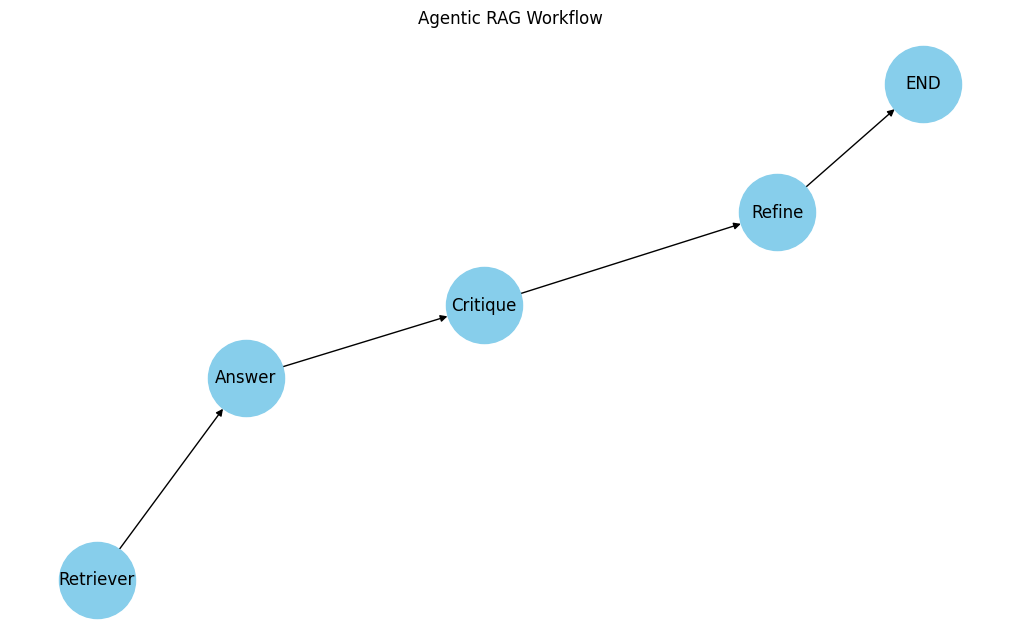

2025/10/04 00:53:51 INFO mlflow.tracking.fluent: Experiment with name 'Agentic_RAG_Workflow' does not exist. Creating a new experiment.


Retriever: ['[KB1] snippet for What are best practices for debugging?', '[KB2] snippet for What are best practices for debugging?', '[KB3] snippet for What are best practices for debugging?', '[KB4] snippet for What are best practices for debugging?', '[KB5] snippet for What are best practices for debugging?']
LLM Answer: Answer for 'What are best practices for debugging?' using snippets ['[KB1] snippet for What are best practices for debugging?', '[KB2] snippet for What are best practices for debugging?', '[KB3] snippet for What are best practices for debugging?', '[KB4] snippet for What are best practices for debugging?', '[KB5] snippet for What are best practices for debugging?']
Critique complete? True


In [40]:
# Imports
import os
import mlflow
import networkx as nx
import matplotlib.pyplot as plt
from pydantic import BaseModel
from langgraph.graph import StateGraph, END

# -------------------------------
# 1. Define RAG State using Pydantic
# -------------------------------
class RAGState(BaseModel):
    query: str
    retrieved_snippets: list = []
    initial_answer: str = ""
    critique_complete: bool = False
    refined_answer: str = ""
    refined_query: str = ""

# -------------------------------
# 2. Define Node Functions
# -------------------------------
def retriever_node(state: RAGState):
    # Example: fetch top 5 snippets (pseudo-code)
    state.retrieved_snippets = [f"[KB{i}] snippet for {state.query}" for i in range(1,6)]
    mlflow.log_text(str(state.retrieved_snippets), "retrieved_snippets.txt")
    print("Retriever:", state.retrieved_snippets)
    return state

def llm_answer_node(state: RAGState):
    # Example: generate answer from snippets
    state.initial_answer = f"Answer for '{state.query}' using snippets {state.retrieved_snippets}"
    mlflow.log_text(state.initial_answer, "initial_answer.txt")
    print("LLM Answer:", state.initial_answer)
    return state

def critique_node(state: RAGState):
    # Example grader logic
    state.critique_complete = len(state.query) % 2 == 0  # dummy grader: True if query length even
    mlflow.log_param("critique_complete", state.critique_complete)
    print("Critique complete?", state.critique_complete)
    return state

def refinement_node(state: RAGState):
    # Only called if critique_complete == False
    state.refined_query = state.query + " (refined)"
    state.refined_answer = f"Refined answer for '{state.refined_query}' using extra snippet [KB6]"
    mlflow.log_text(state.refined_answer, "refined_answer.txt")
    print("Refined Query:", state.refined_query)
    print("Refined Answer:", state.refined_answer)
    return state

# -------------------------------
# 3. Build LangGraph workflow
# -------------------------------
workflow = StateGraph(RAGState)

workflow.add_node("Retriever", retriever_node)
workflow.add_node("Answer", llm_answer_node)
workflow.add_node("Critique", critique_node)
workflow.add_node("Refine", refinement_node)

workflow.set_entry_point("Retriever")

workflow.add_edge("Retriever", "Answer")
workflow.add_edge("Answer", "Critique")
workflow.add_conditional_edges(
    "Critique",
    lambda state: "Refine" if not state.critique_complete else None,
    {"Refine": "Refine"}  # None → END automatically
)
workflow.add_edge("Refine", END)

# -------------------------------
# 4. Visualize workflow with NetworkX
# -------------------------------
nodes = ["Retriever", "Answer", "Critique", "Refine", "END"]
edges = [("Retriever","Answer"),("Answer","Critique"),("Critique","Refine"),("Refine","END")]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

plt.figure(figsize=(10,6))
nx.draw(G, with_labels=True, node_size=3000, node_color="skyblue", arrows=True)
plt.title("Agentic RAG Workflow")
plt.show()

# -------------------------------
# 5. Run workflow with MLflow logging
# -------------------------------
mlflow.set_experiment("Agentic_RAG_Workflow")
with mlflow.start_run(run_name="run_1"):
    user_query = "What are best practices for debugging?"
    state = RAGState(query=user_query)
    
    # Execute nodes in sequence manually
    state = retriever_node(state)
    state = llm_answer_node(state)
    state = critique_node(state)
    if not state.critique_complete:
        state = refinement_node(state)
    
    # Log final state
    mlflow.log_text(state.initial_answer, "final_initial_answer.txt")
    if state.refined_answer:
        mlflow.log_text(state.refined_answer, "final_refined_answer.txt")



✅ Features of This Notebook
Pydantic State: ensures all attributes exist and typed.

Tracing / Printing: prints current node, query, initial answer, grader output, refined query/answer.

MLflow Logging: logs snippets, answers, grader results, refined answer.

Workflow Graph: visualized inline with NetworkX + Matplotlib.

Conditional refinement: only executes Refine if critique_complete is False.

### Thank You!